### They inner atoms, and the outer atoms are equally spaced

In [1]:
from tqdm import tqdm
from qutip import *
import numpy as np

from scipy.optimize import minimize

import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial

In [2]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [68]:
fixed_lam = 1
fixed_gamma = 1

fixed_dist_ext = 0.235  * fixed_lam
fixed_dist_in  =  fixed_dist_ext
########################################                 Define constants                   #############################################
N = 3 + 3 * 10

t_max    = 400
t_size    = 2000

########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma

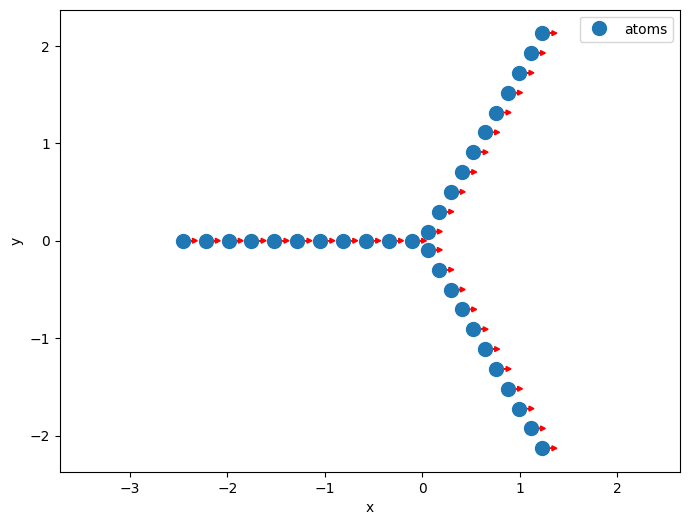

In [41]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = 0):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])

def chain_positions(distance, N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    Pos = np.zeros((N, 3))
#    Chain = chain_positions(distance_ext, N // 3)
#    theta = np.arcsin(1/2)
#    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
#    Pos = Pos[Pos[:, 0].argsort()]
#    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_in * np.cos(theta), +distance_in * np.sin(theta), 0]
#    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_in * np.cos(theta), -distance_in * np.sin(theta), 0]
# HERE IT HAS A DIFFERENT ANGLE! (ORIGIN in middle of triangle) # TODO
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(distance_ext, N // 3) + [r, 0, 0]
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    
    return Pos
# Function to create positions for a topology with three chains meeting at the origin
def topo_positions_only_1_inner(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    if distance_in >= 2 * distance_ext:
        raise ValueError("The distance distance_in is too large to form a valid triangle with distance_ext.")
    Pos = np.zeros((N, 3))
    Chain = chain_positions(distance_ext, N // 3)
    theta = np.arcsin(distance_in / (2 * distance_ext))
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_ext * np.cos(theta), +distance_ext * np.sin(theta), 0]
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_ext * np.cos(theta), -distance_ext * np.sin(theta), 0]
    
    return Pos

positions = topo_positions(0.8 * fixed_dist_in, fixed_dist_in)
initial_angles = np.zeros(N)
dipoles = [0.1 *dipole_vector(angle) for angle in initial_angles]
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
for i, position in enumerate(positions):
    plt.arrow(position[0], position[1], dipoles[i][0], dipoles[i][1], 
             head_width=0.05, head_length=0.05, fc='r', ec='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

In [29]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions_only_1_inner(distance_in, distance_ext)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                G_matrix[a, b] = np.imag((6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions_only_1_inner(distance_in, distance_ext)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                V_matrix[a, b] = np.real((3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix
    
def H_eff(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma):
    G = Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    V = V_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    return Qobj(V) - 1j / 2 * Qobj(G)

# Investigate Photon storage

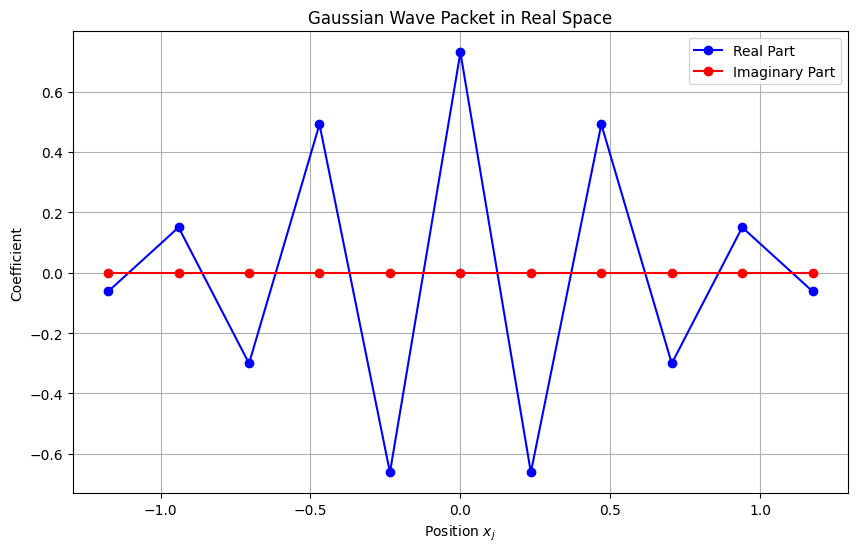

Quantum object: dims=[[33], [1]], shape=(33, 1), type='ket', dtype=Dense
Qobj data =
[[-0.0424681 ]
 [ 0.10323599]
 [-0.20600282]
 [ 0.33743405]
 [-0.45370999]
 [ 0.50077367]
 [-0.45370999]
 [ 0.33743405]
 [-0.20600282]
 [ 0.10323599]
 [-0.0424681 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

In [31]:
################ initiate Wave-packet
k_s = np.pi / fixed_dist_ext
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist_ext)
center_index = N // 6
x_j = (np.arange(N//3) - center_index) * fixed_dist_ext

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()

# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
#psi0 = basis(N,0)
psi0

In [33]:
# ###############
# For Optimization and plotting
# ###############
from scipy.optimize import minimize
def survival_probabilities(dipoles, distance_in, times, distance_ext=fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma, Psi_0=psi0):
    H = H_eff(distance_in, distance_ext, dipoles, lam, gamma)
    coeffs_sq_mods  = np.zeros((len(times), N))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

def dipole_angles_and_distance(params):
    angles = params[:N]
    distance_in = params[N]
    dipoles = [dipole_vector(angle) for angle in angles]
    return dipoles, distance_in

def optimization_target(params, times, target_indices):
    dipoles, distance_in = dipole_angles_and_distance(params)
    res, _ = survival_probabilities(dipoles, distance_in, times)
    # Sum probabilities of the states in the target indices
    target_prob = np.sum(res[-1, target_indices])
    # We want to maximize the target probability
    return -target_prob

# Initial guess for the distance
initial_distance = 0.234 * fixed_lam
initial_angles = np.zeros(N)
initial_params = np.hstack((initial_angles, initial_distance))

# Bounds for the optimization
angle_bounds = [(0, 2*np.pi) for _ in range(N)]
distance_in_bounds = [(0.1, 1)]
bounds = angle_bounds + distance_in_bounds

# Indices of the atoms in the target regions
target_indices = list(range(N//3, 2*N//3-1))  # Example, assuming the target regions are the second third

# Optimization with bounds
#result = minimize(optimization_target, initial_params, args=(times, target_indices), bounds=bounds, method='SLSQP')

# Debugging print statements
print("Optimization result:", result)

# Extract optimized parameters
optimized_angles = result.x[:N]
optimized_distance_in = result.x[N]

# Print results
print("Optimized Angles:", optimized_angles)
print("Optimized Inner Distance:", optimized_distance_in)

Optimization result:  message: Iteration limit reached
 success: False
  status: 9
     fun: -0.9344508484012344
       x: [ 8.562e-01  5.454e-01 ...  8.607e-04  2.338e-01]
     nit: 100
     jac: [ 6.191e-05  1.431e-04 ... -8.278e-06  3.640e-02]
    nfev: 3536
    njev: 100
Optimized Angles: [8.56243885e-01 5.45393047e-01 3.85418697e-01 3.18513591e-01
 3.09201236e-01 3.18809638e-01 3.02352737e-01 2.45478456e-01
 1.90687899e-01 1.81840059e-01 2.92083938e-01 6.11810003e-01
 9.01226926e-01 1.11087273e+00 1.33708053e+00 1.48645068e+00
 1.33431484e+00 1.03719638e+00 7.11143820e-01 3.11570521e-01
 0.00000000e+00 2.75855356e-19 6.56744532e-01 0.00000000e+00
 2.70445385e-19 4.83460526e-02 1.36868323e-01 2.92998383e-04
 2.99060327e-02 4.23999898e-03 1.86039360e-02 4.04483397e-03
 8.60705448e-04]
Optimized Inner Distance: 0.23377574006703314


In [69]:
dip, dist = dipole_angles_and_distance(result.x)
dip[-7] = np.array([1,0,0])
dip[-8] = np.array([1,0,0])

y1, y2 = survival_probabilities(dip, dist, times, Psi_0=psi0)

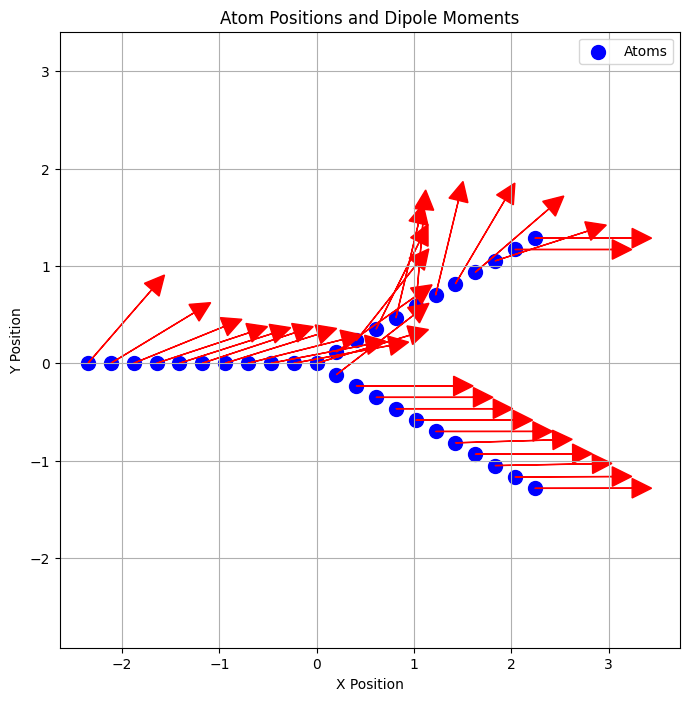

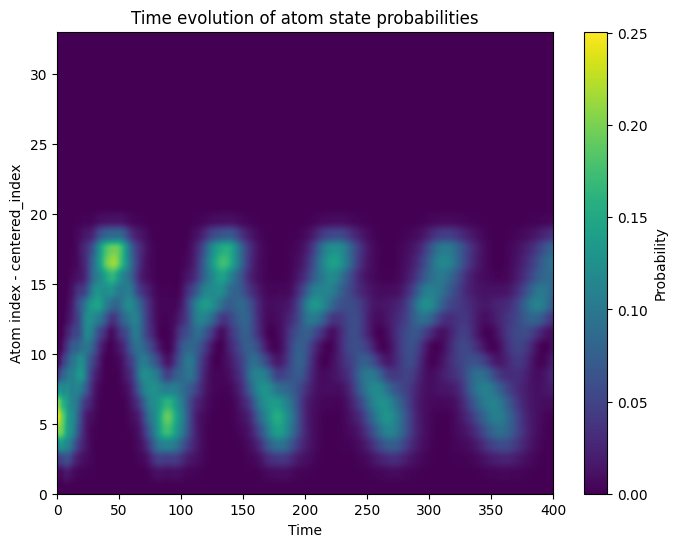

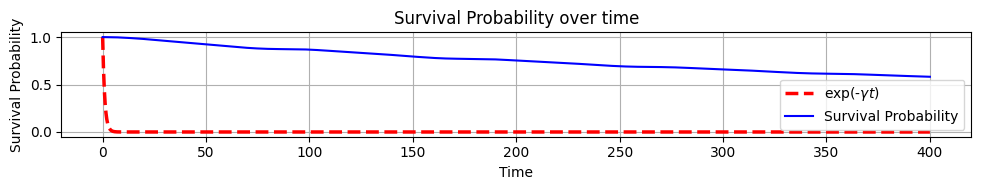

In [72]:
# Plot atoms with their dipole moments
positions = topo_positions_only_1_inner(optimized_distance_in)
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i, position in enumerate(positions):
    plt.arrow(position[0], position[1], dip[i][0], dip[i][1], head_width=0.2, head_length=0.2, fc='r', ec='r')
plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()
# Create a heatmap for state probabilities
plt.figure(figsize=(8, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index - centered_index')
plt.title('Time evolution of atom state probabilities')
plt.show()

# Plot survival probability
plt.figure(figsize=(10, 2))
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.plot(times, y2, 'b-', label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()